In [1]:
! pip install rdkit pysmiles prettytable pybel huggingface_hub ijson datasets

Cores: 24, GPUs: 1

Database shape: (41801, 20)


Defining SMILES vocabulary



[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    9.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:   12.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   16.1s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   19.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   23.9s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:   28.5s
[Parallel(n_jobs=24)]: Done 11202 tasks 


Size of vocabulary: 33

41801
Check packing shape: torch.Size([41801, 224, 1])

Max length = 224

Max length of tensor sequences: 224

Test size: (2091, 224)


Train size: (39710, 224)

Cuda available: True

 HOMO NN 

Epoch: 0001 [] Train (Loss=0.093 | Metric=0.022)	Val. (MAE=0.019 | HL=0.000)
Epoch: 0002 [] Train (Loss=0.021 | Metric=0.000)	Val. (MAE=0.018 | HL=0.000)
Epoch: 0003 [] Train (Loss=0.017 | Metric=0.000)	Val. (MAE=0.023 | HL=0.000)
Epoch: 0004 [] Train (Loss=0.017 | Metric=0.000)	Val. (MAE=0.014 | HL=0.000)
Epoch: 0005 [] Train (Loss=0.016 | Metric=0.000)	Val. (MAE=0.014 | HL=0.000)
Epoch: 0006 [] Train (Loss=0.015 | Metric=0.000)	Val. (MAE=0.015 | HL=0.000)
Epoch: 0007 [] Train (Loss=0.015 | Metric=0.000)	Val. (MAE=0.015 | HL=0.000)
Epoch: 0008 [] Train (Loss=0.015 | Metric=0.000)	Val. (MAE=0.015 | HL=0.000)
Epoch: 0009 [] Train (Loss=0.014 | Metric=0.000)	Val. (MAE=0.014 | HL=0.000)
Epoch: 0010 [] Train (Loss=0.014 | Metric=0.000)	Val. (MAE=0.014 | HL=0.000)
Epoch: 001

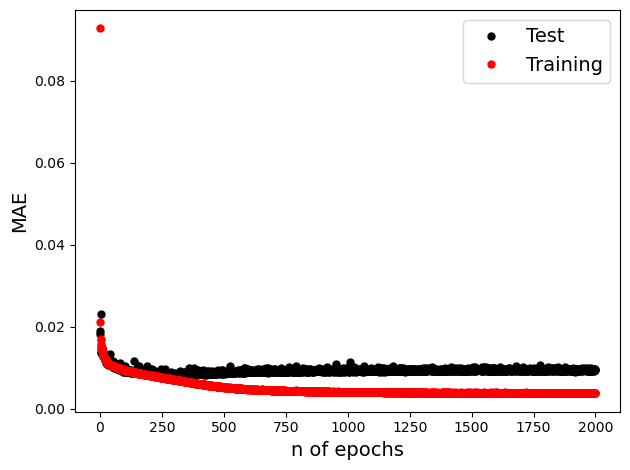

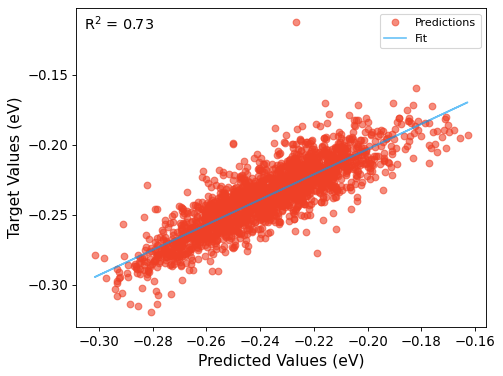

In [2]:
import typing_extensions
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import multiprocessing
from scipy import stats
import os, sys
import time
import json

start = time.time()

file_dir = os.path.dirname("../")
sys.path.append(file_dir)

from anima.smiles import SMILES

sml = SMILES()

cores = int(multiprocessing.cpu_count())
print(f"Cores: {cores}, GPUs: {torch.cuda.device_count()}")

database = pd.read_csv("../anima-master/databases/OMEAD_41801.csv")

print(f"\nDatabase shape: {database.shape}\n")

train_db = database
smiles = np.array(train_db.smiles)

# Define SMILES vocabulary

print("\nDefining SMILES vocabulary\n")
vocab = sml.smilesVOC(smiles, n_jobs=cores)

vocab_size = len(vocab)

print(f"\nSize of vocabulary: {vocab_size}\n")

#saving the vocabulary
with open('vocab.dat', 'w') as f:
    for i in vocab:
        f.write(str(i) + '\n')


# Preparing SMILES into SEQUENCES or 1h tensors
# for embeddings
all_sequences = []

l = 1
for i in smiles:
    print(l, end="\r")
    all_sequences.append(torch.tensor(sml.smilesToSequence(i, vocab)))
    l += 1


# for embeddings
packing = torch.nn.utils.rnn.pack_sequence(
    all_sequences,
    enforce_sorted = False
)

packing_padding = torch.nn.utils.rnn.pad_packed_sequence(
    packing,
    batch_first = True
)

# Check dimensions
# for embedding
# BATCH x SEQUENCE x INFO
print(f"\nCheck packing shape: {packing_padding[0][:,:,:].size()}\n")

temp = packing_padding[0][:,:,0]
random_state = 1
test_size = 0.05

# inputs
x_train, x_test = train_test_split(
    temp.numpy(),
    test_size=test_size,
    random_state=1
)
del temp

homo = np.array(train_db.homo)
# targets / outputs
y_train, y_test = train_test_split(
    homo,
    test_size=test_size,
    random_state=1
)

max_length = x_train.shape[-1]
print(f"Max length = {max_length}")

# Store max length from training for prediction
config = {"max_length": max_length}
with open("config.json", "w") as f:
    json.dump(config, f)
    f.close()


# max length of tensor sequences
print(f"\nMax length of tensor sequences: {x_train.shape[-1]}")

print(f"\nTest size: {x_test.shape}\n")
print(f"\nTrain size: {x_train.shape}\n")


# Define TOOLS
def model_evaluation(model, x_test, y_test, device):
    batch_size=64

    test_data = TensorDataset(
        torch.tensor(x_test),
        torch.tensor(y_test)
    )

    test_loader = DataLoader(
        test_data,
        shuffle= False,
        batch_size= batch_size,
        drop_last = False
    )

    running_mae = []
    running_mse = []
    mae = torch.nn.L1Loss().to(device)
    mse = torch.nn.SmoothL1Loss().to(device)

    model.eval().to(device)

    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.double()

            output = model(inputs)

            loss_mae = mae(output, targets)
            loss_mse = mse(output, targets)

            running_mae.append(loss_mae.item())
            running_mse.append(loss_mse.item())
            
    model.train()
    return np.mean(running_mae), np.mean(running_mse)


def model_predictions(model, x, device, batch_size = 64):
    # predictions

    model.eval().to(device)

    pred_data = TensorDataset(torch.tensor(x))
    pred_loader = DataLoader(
        pred_data,
        shuffle=False,
        batch_size=batch_size,
        drop_last=False,
    )

    batches = len(x) / batch_size

    with torch.no_grad():
        for batch_idx, data in enumerate(pred_loader):
            print(f"Batch: {batch_idx + 1:010.2f} of {batches:010.2f}", end="\r")
            inputs = data[0]
            inputs = inputs.to(device)

            output = model(inputs)
            if batch_idx == 0:
                temp = output.cpu().detach().numpy()
            else:
                temp = np.append(temp, output.cpu().detach().numpy())
            del inputs, output

    return np.reshape(temp, -1)


# Defining the NN model
class NN(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, decoder_in, decoder_out, vocab_size, emb_dim, max_length, dropout, nr_GRU):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.nr_GRU = nr_GRU  # Instead of separate GRUs, we loop over these

        # Define GRUs dynamically
        self.grus = torch.nn.ModuleList([
            torch.nn.GRU(emb_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
            for _ in range(self.nr_GRU)
        ])

        # Define fully connected layers
        self.fc_layers = torch.nn.ModuleList([
            torch.nn.Linear(hidden_dim, decoder_in) for _ in range(self.nr_GRU)
        ])

        # Decoder layers
        self.decoder = torch.nn.Linear(max_length * self.nr_GRU * decoder_in, decoder_out)
        self.output = torch.nn.Linear(decoder_out, output_dim)

        # Activation and embeddings
        self.activation = torch.nn.Mish()
        self.embeddings = torch.nn.Embedding(vocab_size + 1, emb_dim, max_norm=1.0, padding_idx=0)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, inputs):
        batch_size = inputs.shape[0]
        inputs = self.embeddings(inputs)

        hidden = self.init_hidden(batch_size)
        gru_outputs = []

        for i, gru in enumerate(self.grus):
            out, hidden = gru(inputs, hidden)
            out = self.activation(self.fc_layers[i](out))
            gru_outputs.append(out)

        # Concatenate outputs
        cat = torch.cat(gru_outputs, dim=-1).reshape(batch_size, -1)
        cat = self.activation(cat)

        # Decode output
        decoder = self.activation(self.decoder(cat))
        decoder = self.dropout(decoder)
        output = self.output(decoder)

        return output[:, 0]

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_dim, dtype=torch.float, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
	


# Checking CUDA
use_cuda = True
print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device(
    "cuda" if (use_cuda and torch.cuda.is_available()) else "cpu"
)
torch.cuda.set_per_process_memory_fraction(0.9, device=0) # Limits GPU usage to 90%

print("\n HOMO NN \n")

epochs = 2000
all_data = len(x_train)
log = 10

# Read best params from evo algorithm
with open('best_param_HOMO.json', 'r') as f:
    best_params = json.load(f)
    f.close()

decoder_in = best_params["decoder_in"]
decoder_out = best_params["decoder_out"]
hidden_dim = best_params["hidden_dim"]
n_layers = best_params["n_layers"]
emb_dim = best_params["emb_dim"]
output_dim = 1
batch_size = best_params["batch_size"]
dropout = best_params["dropout"]
weight_decay = best_params["weight_decay"]
#nr_GRU = best_params["nn_GRU"]
nr_GRU = 4


#decoder_in = 32
#decoder_out = 64
#hidden_dim = 128
#n_layers = 3
#emb_dim = 256
#output_dim = 1
#batch_size = 256
#dropout = 0.15
#weight_decay = 1e-5
#nr_GRU = 4

nn_homo = NN(hidden_dim, output_dim, n_layers, decoder_in, decoder_out, vocab_size, emb_dim, max_length, dropout, nr_GRU)
nn_homo = nn_homo.float().to(device)

# loss
metric = torch.nn.SmoothL1Loss().double()
optimizer = torch.optim.Adam(nn_homo.parameters(), lr=0.001, weight_decay=weight_decay)

# setting the dataloader
train_data = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False, pin_memory=True)


epoch_loss = []
test_loss = []

for epoch in range(epochs):

    running_loss = []
    running_metric = []
    for batch_idx, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0]
        targets = data[1]
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.double()

        optimizer.zero_grad()

        output = nn_homo(inputs)

        loss = torch.mean(torch.abs(targets - output))
        loss.backward()
        optimizer.step()

        # Print statistics every log
        running_loss.append(loss.item())
        running_metric.append(metric(output, targets).item())
        if batch_idx % log == 0:
            print(f"Epoch {epoch+1:04d} [{batch_idx * len(inputs):05d}/{all_data:05d} ({100 * batch_idx * batch_size / len(train_data):04.1f})%] \t\t Loss: {np.mean(running_loss):02.3f}", end="\r")

    epoch_loss.append(np.mean(running_loss))
    test_mae, test_mse = model_evaluation(nn_homo, x_test, y_test, device)
    test_loss.append(test_mae)

    print(f"Epoch: {epoch + 1:04d} [] Train (Loss={np.mean(running_loss):02.3f} | Metric={np.mean(running_metric):02.3f})\tVal. (MAE={test_mae:02.3f} | HL={test_mse:02.3f})", end="\n")

print("\n")
print(f"\n Train Loss: {round(epoch_loss[-1], 2)}")
print(f"\n Test MAE: {round(test_loss[-1], 2)}")
print("\n Finished training")


# Plot training and test errors
plt.plot(range(epoch + 1), test_loss, 'o', c='black', ms=5, label='Test')
plt.plot(range(epoch + 1), epoch_loss, 'o', c='red', ms=5, label='Training')
plt.xlabel("n of epochs", size=14)
plt.ylabel("MAE", size=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("Train_test_errors.png", dpi=200)


predictions = model_predictions(nn_homo, x_test, device, batch_size=64)

px = predictions.reshape(-1)
py = y_test.reshape(-1)
    
# Generate linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(px, py)
line = slope * px + intercept
conf = std_err * 2.58  # 99% confidence interval

fig, axs = plt.subplots(1, 1, dpi=80)
axs.tick_params(axis="both", which="major", labelsize=12)

axs.plot(px, py, "o", color="xkcd:tomato", aa=True, alpha=0.6, label="Predictions")
axs.plot(px, line, color="xkcd:azure", aa=True, alpha=0.6, label="Fit")

axs.set_ylabel(r"Target Values (eV)", fontsize=14)
axs.set_xlabel("Predicted Values (eV)", fontsize=14)
axs.text(0.02, 0.98, f"R$^2$ = {r_value**2:.2f}", transform=axs.transAxes,
         fontsize=13, ha="left", va="top")
axs.legend()

fig.tight_layout()
plt.savefig("Linear_reg.png", dpi=200)


### save the model

torch.save(nn_homo.state_dict(), 'nn_homo.pt')
torch.save(nn_homo, 'nn_homo.pt_full')

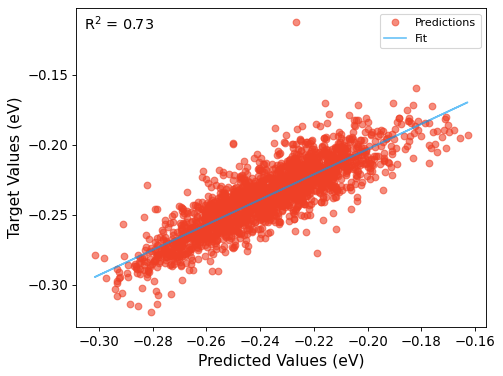

In [3]:
# Generate linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(px, py)
line = slope * px + intercept
conf = std_err * 2.58  # 99% confidence interval

fig, axs = plt.subplots(1, 1, dpi=80)
axs.tick_params(axis="both", which="major", labelsize=12)

axs.plot(px, py, "o", color="xkcd:tomato", aa=True, alpha=0.6, label="Predictions")
axs.plot(px, line, color="xkcd:azure", aa=True, alpha=0.6, label="Fit")

axs.set_ylabel(r"Target Values (eV)", fontsize=14)
axs.set_xlabel("Predicted Values (eV)", fontsize=14)
axs.text(0.02, 0.98, f"R$^2$ = {r_value**2:.2f}", transform=axs.transAxes,
         fontsize=13, ha="left", va="top")
axs.legend()

fig.tight_layout()